# TACO Dataset Integration

This notebook downloads and integrates the TACO (Trash Annotations in Context) dataset.

**TACO provides:**
- ~4600 images with bounding box annotations
- 60 waste categories
- Real-world waste images in various contexts

We will:
1. Download images from URLs
2. Parse COCO-format annotations
3. Map TACO categories to our 4 categories
4. Add to our existing dataset
5. Optionally retrain models

## 1. Setup

In [1]:
import os
import sys
from pathlib import Path
import json
import shutil
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import yaml
from tqdm import tqdm

# Project root
PROJECT_ROOT = Path(r"c:/Users/anike/Downloads/WasteSegregation")
sys.path.insert(0, str(PROJECT_ROOT))

# Paths
TACO_PATH = PROJECT_ROOT / "datasets" / "raw" / "taco"
TACO_IMAGES_PATH = TACO_PATH / "images"
TACO_IMAGES_PATH.mkdir(parents=True, exist_ok=True)

PROCESSED_PATH = PROJECT_ROOT / "datasets" / "processed"

print(f"Project Root: {PROJECT_ROOT}")
print(f"TACO Path: {TACO_PATH}")
print(f"\n✅ Setup complete!")

Project Root: c:\Users\anike\Downloads\WasteSegregation
TACO Path: c:\Users\anike\Downloads\WasteSegregation\datasets\raw\taco

✅ Setup complete!


## 2. Load TACO Annotations

In [2]:
# Load annotations
annotations_path = TACO_PATH / "annotations.json"

with open(annotations_path, 'r') as f:
    taco_data = json.load(f)

print("📋 TACO Dataset Structure:")
print("=" * 50)
print(f"   Images: {len(taco_data['images'])}")
print(f"   Annotations: {len(taco_data['annotations'])}")
print(f"   Categories: {len(taco_data['categories'])}")

# Show categories
print("\n📂 TACO Categories:")
for cat in taco_data['categories']:
    print(f"   {cat['id']:2d}: {cat['name']}")

📋 TACO Dataset Structure:
   Images: 1500
   Annotations: 4784
   Categories: 60

📂 TACO Categories:
    0: Aluminium foil
    1: Battery
    2: Aluminium blister pack
    3: Carded blister pack
    4: Other plastic bottle
    5: Clear plastic bottle
    6: Glass bottle
    7: Plastic bottle cap
    8: Metal bottle cap
    9: Broken glass
   10: Food Can
   11: Aerosol
   12: Drink can
   13: Toilet tube
   14: Other carton
   15: Egg carton
   16: Drink carton
   17: Corrugated carton
   18: Meal carton
   19: Pizza box
   20: Paper cup
   21: Disposable plastic cup
   22: Foam cup
   23: Glass cup
   24: Other plastic cup
   25: Food waste
   26: Glass jar
   27: Plastic lid
   28: Metal lid
   29: Other plastic
   30: Magazine paper
   31: Tissues
   32: Wrapping paper
   33: Normal paper
   34: Paper bag
   35: Plastified paper bag
   36: Plastic film
   37: Six pack rings
   38: Garbage bag
   39: Other plastic wrapper
   40: Single-use carrier bag
   41: Polypropylene bag
   42: 

In [3]:
# Create category mapping from TACO to our 4 categories
# Based on TACO's supercategories and category names

TACO_TO_OUR_CATEGORIES = {
    # Recyclable items
    'Aluminium foil': 'recyclable',
    'Clear plastic bottle': 'recyclable',
    'Glass bottle': 'recyclable',
    'Other plastic bottle': 'recyclable',
    'Plastic bottle cap': 'recyclable',
    'Metal bottle cap': 'recyclable',
    'Drink can': 'recyclable',
    'Food can': 'recyclable',
    'Aerosol': 'recyclable',
    'Drink carton': 'recyclable',
    'Corrugated carton': 'recyclable',
    'Meal carton': 'recyclable',
    'Pizza box': 'recyclable',
    'Egg carton': 'recyclable',
    'Paper cup': 'recyclable',
    'Disposable plastic cup': 'recyclable',
    'Foam cup': 'general',  # Foam is typically not recyclable
    'Glass cup': 'recyclable',
    'Other plastic cup': 'recyclable',
    'Paper bag': 'recyclable',
    'Plastic film': 'general',  # Soft plastic often not recyclable
    'Six pack rings': 'recyclable',
    'Garbage bag': 'general',
    'Single-use carrier bag': 'general',
    'Polypropylene bag': 'recyclable',
    'Crisp packet': 'general',
    'Spread tub': 'recyclable',
    'Tupperware': 'recyclable',
    'Disposable food container': 'recyclable',
    'Foam food container': 'general',
    'Other plastic container': 'recyclable',
    'Plastic lid': 'recyclable',
    'Metal lid': 'recyclable',
    'Other plastic': 'general',
    'Magazine paper': 'recyclable',
    'Tissues': 'general',
    'Wrapping paper': 'recyclable',
    'Normal paper': 'recyclable',
    'Paper straw': 'recyclable',
    'Plastic straw': 'general',
    'Styrofoam piece': 'general',
    'Other plastic wrapper': 'general',
    'Plastic utensils': 'general',
    'Squeezable tube': 'general',
    'Pop tab': 'recyclable',
    'Rope & strings': 'general',
    'Scrap metal': 'recyclable',
    'Shoe': 'general',
    'Cigarette': 'general',
    
    # E-waste items
    'Battery': 'e-waste',
    'Blister pack': 'general',
    
    # Organic items (food-related that could be organic)
    'Food waste': 'organic',
    
    # General/catch-all
    'Unlabeled litter': 'general',
    'Broken glass': 'general',  # Hazardous, not regular recycling
}

# Create ID to category mapping
taco_id_to_name = {cat['id']: cat['name'] for cat in taco_data['categories']}
taco_id_to_our_category = {}

for cat in taco_data['categories']:
    cat_name = cat['name']
    our_cat = TACO_TO_OUR_CATEGORIES.get(cat_name, 'general')
    taco_id_to_our_category[cat['id']] = our_cat

print("📋 Category Mapping Created:")
category_counts = {'recyclable': 0, 'organic': 0, 'e-waste': 0, 'general': 0}
for cat_id, our_cat in taco_id_to_our_category.items():
    category_counts[our_cat] += 1

for cat, count in category_counts.items():
    print(f"   {cat}: {count} TACO categories")

📋 Category Mapping Created:
   recyclable: 32 TACO categories
   organic: 1 TACO categories
   e-waste: 1 TACO categories
   general: 26 TACO categories


## 3. Download TACO Images

⚠️ **Note:** This will download ~1500 images (~500MB). This may take 10-30 minutes depending on internet speed.

In [4]:
def download_image(url, save_path, timeout=30):
    """
    Download an image from URL.
    """
    try:
        response = requests.get(url, timeout=timeout, stream=True)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            return True
        return False
    except Exception as e:
        return False


def download_taco_images(taco_data, save_dir, max_images=None, max_workers=8):
    """
    Download TACO images in parallel.
    """
    images = taco_data['images']
    if max_images:
        images = images[:max_images]
    
    # Check which images already exist
    to_download = []
    for img in images:
        save_path = save_dir / img['file_name'].replace('/', '_')
        if not save_path.exists():
            to_download.append((img, save_path))
    
    print(f"📥 Images to download: {len(to_download)} (already have {len(images) - len(to_download)})")
    
    if len(to_download) == 0:
        print("✅ All images already downloaded!")
        return len(images), 0
    
    successful = 0
    failed = 0
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {}
        for img, save_path in to_download:
            url = img.get('flickr_640_url') or img.get('flickr_url')
            if url:
                future = executor.submit(download_image, url, save_path)
                futures[future] = img['file_name']
        
        with tqdm(total=len(futures), desc="Downloading") as pbar:
            for future in as_completed(futures):
                if future.result():
                    successful += 1
                else:
                    failed += 1
                pbar.update(1)
    
    return successful, failed


# Check current status
existing = list(TACO_IMAGES_PATH.glob("*.jpg")) + list(TACO_IMAGES_PATH.glob("*.png"))
print(f"📂 Existing images in TACO folder: {len(existing)}")
print(f"📂 Total images in annotations: {len(taco_data['images'])}")

📂 Existing images in TACO folder: 0
📂 Total images in annotations: 1500


In [5]:
# Download images (you can set max_images to limit for testing)
# Set to None to download all ~1500 images

MAX_IMAGES = 500  # Set to None for all images, or a number to limit

print(f"🚀 Starting download (max {MAX_IMAGES or 'all'} images)...")
print("⏳ This may take several minutes...\n")

successful, failed = download_taco_images(
    taco_data, 
    TACO_IMAGES_PATH, 
    max_images=MAX_IMAGES,
    max_workers=8
)

print(f"\n✅ Download complete!")
print(f"   Successful: {successful}")
print(f"   Failed: {failed}")

🚀 Starting download (max 500 images)...
⏳ This may take several minutes...

📥 Images to download: 500 (already have 0)


Downloading: 100%|██████████| 500/500 [22:04<00:00,  2.65s/it]  


✅ Download complete!
   Successful: 499
   Failed: 1


📂 Total images in TACO folder: 500


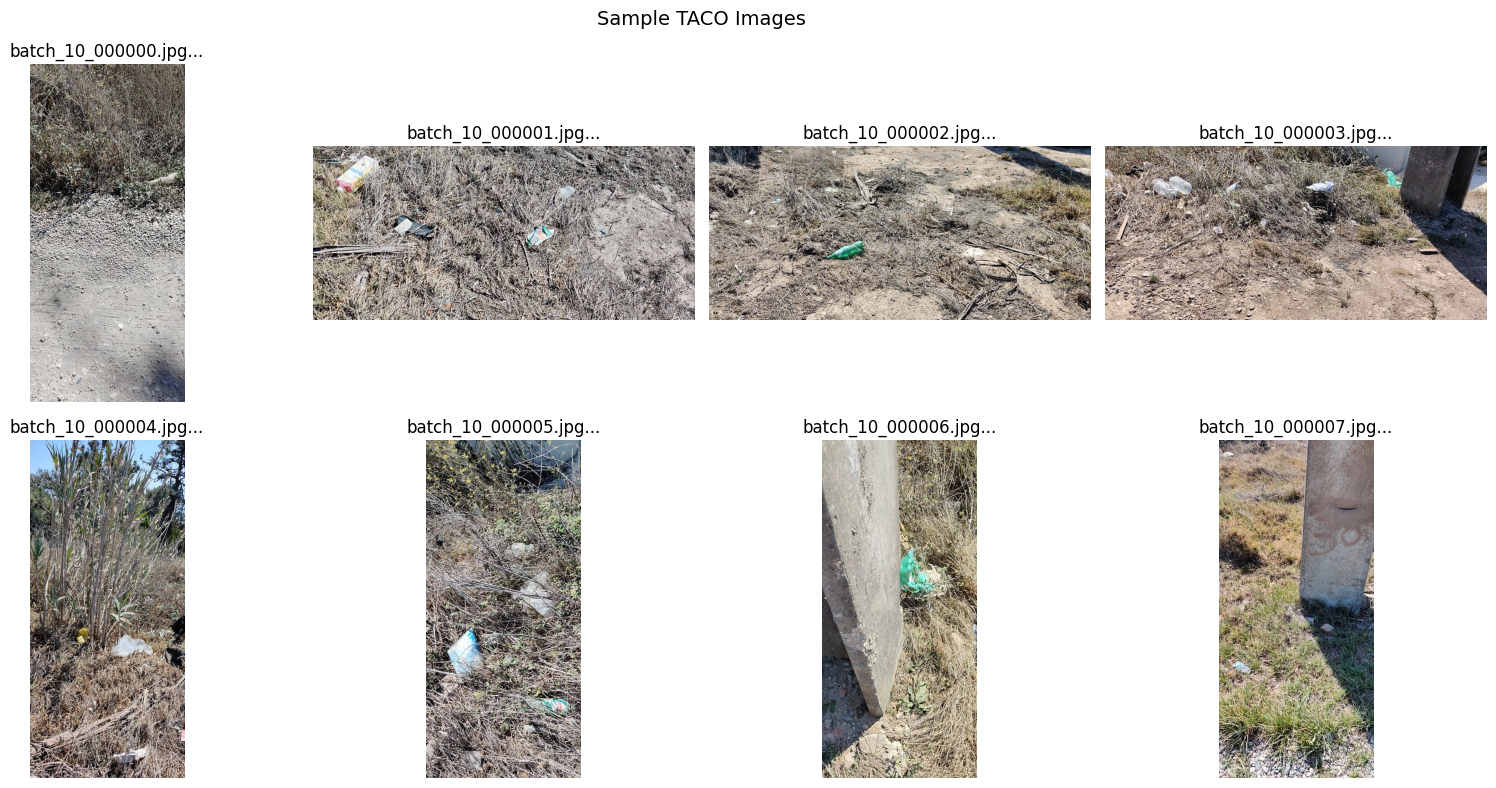

In [6]:
# Verify downloaded images
downloaded = list(TACO_IMAGES_PATH.glob("*.*"))
print(f"📂 Total images in TACO folder: {len(downloaded)}")

# Show sample
if len(downloaded) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(downloaded):
            try:
                img = Image.open(downloaded[i])
                ax.imshow(img)
                ax.set_title(downloaded[i].name[:20] + "...")
            except:
                ax.text(0.5, 0.5, "Error", ha='center')
        ax.axis('off')
    
    plt.suptitle('Sample TACO Images', fontsize=14)
    plt.tight_layout()
    plt.show()

## 4. Process TACO for Classification

In [7]:
def get_image_category(image_id, annotations, id_to_category):
    """
    Get the primary category for an image based on annotations.
    If multiple objects, use the most common category.
    """
    image_annotations = [a for a in annotations if a['image_id'] == image_id]
    
    if not image_annotations:
        return 'general'
    
    categories = [id_to_category.get(a['category_id'], 'general') for a in image_annotations]
    
    # Return most common
    from collections import Counter
    return Counter(categories).most_common(1)[0][0]


# Build image to category mapping
image_categories = {}
for img in taco_data['images']:
    cat = get_image_category(img['id'], taco_data['annotations'], taco_id_to_our_category)
    image_categories[img['id']] = {
        'file_name': img['file_name'].replace('/', '_'),
        'category': cat
    }

# Count categories
cat_counts = {'recyclable': 0, 'organic': 0, 'e-waste': 0, 'general': 0}
for img_id, info in image_categories.items():
    cat_counts[info['category']] += 1

print("📊 TACO Images by Category:")
for cat, count in cat_counts.items():
    print(f"   {cat}: {count}")

📊 TACO Images by Category:
   recyclable: 655
   organic: 1
   e-waste: 1
   general: 843


In [8]:
def copy_taco_to_processed(image_categories, taco_images_path, processed_path, split='train'):
    """
    Copy TACO images to processed folder structure.
    """
    copied = {'recyclable': 0, 'organic': 0, 'e-waste': 0, 'general': 0}
    skipped = 0
    
    for img_id, info in tqdm(image_categories.items(), desc=f"Copying to {split}"):
        src = taco_images_path / info['file_name']
        
        if not src.exists():
            skipped += 1
            continue
        
        # Destination
        dst_dir = processed_path / split / "classification" / info['category']
        dst_dir.mkdir(parents=True, exist_ok=True)
        
        dst = dst_dir / f"taco_{info['file_name']}"
        
        if not dst.exists():
            try:
                # Load and resize to standard size
                img = cv2.imread(str(src))
                if img is not None:
                    img = cv2.resize(img, (224, 224))
                    cv2.imwrite(str(dst), img)
                    copied[info['category']] += 1
            except Exception as e:
                skipped += 1
    
    return copied, skipped


# Split TACO images: 70% train, 15% val, 15% test
all_image_ids = list(image_categories.keys())
np.random.seed(42)
np.random.shuffle(all_image_ids)

n_total = len(all_image_ids)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

train_ids = all_image_ids[:n_train]
val_ids = all_image_ids[n_train:n_train + n_val]
test_ids = all_image_ids[n_train + n_val:]

print(f"📊 TACO Split:")
print(f"   Train: {len(train_ids)}")
print(f"   Val: {len(val_ids)}")
print(f"   Test: {len(test_ids)}")

📊 TACO Split:
   Train: 1050
   Val: 225
   Test: 225


In [9]:
# Copy images to processed folders
print("📂 Copying TACO images to processed folders...\n")

# Train
train_categories = {img_id: image_categories[img_id] for img_id in train_ids}
train_copied, train_skipped = copy_taco_to_processed(
    train_categories, TACO_IMAGES_PATH, PROCESSED_PATH, 'train'
)
print(f"\n✅ Train: {sum(train_copied.values())} copied, {train_skipped} skipped")
print(f"   {train_copied}")

# Validation
val_categories = {img_id: image_categories[img_id] for img_id in val_ids}
val_copied, val_skipped = copy_taco_to_processed(
    val_categories, TACO_IMAGES_PATH, PROCESSED_PATH, 'val'
)
print(f"\n✅ Val: {sum(val_copied.values())} copied, {val_skipped} skipped")
print(f"   {val_copied}")

# Test
test_categories = {img_id: image_categories[img_id] for img_id in test_ids}
test_copied, test_skipped = copy_taco_to_processed(
    test_categories, TACO_IMAGES_PATH, PROCESSED_PATH, 'test'
)
print(f"\n✅ Test: {sum(test_copied.values())} copied, {test_skipped} skipped")
print(f"   {test_copied}")

📂 Copying TACO images to processed folders...



Copying to train: 100%|██████████| 1050/1050 [00:36<00:00, 28.70it/s]



✅ Train: 364 copied, 686 skipped
   {'recyclable': 151, 'organic': 1, 'e-waste': 1, 'general': 211}


Copying to val: 100%|██████████| 225/225 [00:06<00:00, 34.71it/s]



✅ Val: 68 copied, 157 skipped
   {'recyclable': 27, 'organic': 0, 'e-waste': 0, 'general': 41}


Copying to test: 100%|██████████| 225/225 [00:06<00:00, 36.90it/s]


✅ Test: 68 copied, 157 skipped
   {'recyclable': 25, 'organic': 0, 'e-waste': 0, 'general': 43}


In [10]:
# Verify final dataset counts
print("\n📊 FINAL DATASET COUNTS (TrashNet + TACO):")
print("=" * 60)

for split in ['train', 'val', 'test']:
    split_path = PROCESSED_PATH / split / "classification"
    print(f"\n{split.upper()}:")
    
    total = 0
    for category in ['recyclable', 'organic', 'e-waste', 'general']:
        cat_path = split_path / category
        if cat_path.exists():
            count = len(list(cat_path.glob("*.jpg"))) + len(list(cat_path.glob("*.png")))
            total += count
            print(f"   {category}: {count}")
        else:
            print(f"   {category}: 0")
    print(f"   TOTAL: {total}")


📊 FINAL DATASET COUNTS (TrashNet + TACO):

TRAIN:
   recyclable: 1824
   organic: 1
   e-waste: 1
   general: 306
   TOTAL: 2132

VAL:
   recyclable: 385
   organic: 0
   e-waste: 0
   general: 61
   TOTAL: 446

TEST:
   recyclable: 384
   organic: 0
   e-waste: 0
   general: 65
   TOTAL: 449


## 5. Process TACO for YOLO Detection (Optional)

In [11]:
def convert_taco_to_yolo(taco_data, taco_images_path, output_path, image_ids):
    """
    Convert TACO annotations to YOLO format.
    """
    images_dir = output_path / "images"
    labels_dir = output_path / "labels"
    images_dir.mkdir(parents=True, exist_ok=True)
    labels_dir.mkdir(parents=True, exist_ok=True)
    
    # Create image ID to annotations mapping
    img_to_annotations = {}
    for ann in taco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in img_to_annotations:
            img_to_annotations[img_id] = []
        img_to_annotations[img_id].append(ann)
    
    # Image ID to info
    img_id_to_info = {img['id']: img for img in taco_data['images']}
    
    copied = 0
    for img_id in tqdm(image_ids, desc="Converting"):
        if img_id not in img_id_to_info:
            continue
        
        img_info = img_id_to_info[img_id]
        src_path = taco_images_path / img_info['file_name'].replace('/', '_')
        
        if not src_path.exists():
            continue
        
        # Copy image
        dst_img = images_dir / f"taco_{img_id}.jpg"
        if not dst_img.exists():
            try:
                img = cv2.imread(str(src_path))
                if img is None:
                    continue
                cv2.imwrite(str(dst_img), img)
            except:
                continue
        
        # Get image dimensions
        img_width = img_info['width']
        img_height = img_info['height']
        
        # Create YOLO labels
        labels = []
        annotations = img_to_annotations.get(img_id, [])
        
        for ann in annotations:
            bbox = ann['bbox']  # [x, y, width, height] in COCO format
            
            # Convert to YOLO format (center_x, center_y, width, height) normalized
            x_center = (bbox[0] + bbox[2] / 2) / img_width
            y_center = (bbox[1] + bbox[3] / 2) / img_height
            w = bbox[2] / img_width
            h = bbox[3] / img_height
            
            # Class 0 for waste (single class detection)
            labels.append(f"0 {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")
        
        # Save labels
        if labels:
            label_path = labels_dir / f"taco_{img_id}.txt"
            with open(label_path, 'w') as f:
                f.write('\n'.join(labels))
            copied += 1
    
    return copied


# Uncomment to also add TACO to YOLO training data
# This adds bounding box annotations for detection

ADD_TO_YOLO = False  # Set to True to add TACO to YOLO dataset

if ADD_TO_YOLO:
    print("📂 Converting TACO to YOLO format...")
    
    yolo_path = PROCESSED_PATH / "detection"
    
    train_copied = convert_taco_to_yolo(
        taco_data, TACO_IMAGES_PATH,
        yolo_path / "train", train_ids
    )
    print(f"   Train: {train_copied} images")
    
    val_copied = convert_taco_to_yolo(
        taco_data, TACO_IMAGES_PATH,
        yolo_path / "val", val_ids
    )
    print(f"   Val: {val_copied} images")
    
    print("\n✅ YOLO conversion complete!")
else:
    print("ℹ️ Skipping YOLO conversion (set ADD_TO_YOLO=True to enable)")

ℹ️ Skipping YOLO conversion (set ADD_TO_YOLO=True to enable)


## 6. Summary

In [12]:
print("=" * 60)
print("🎉 TACO INTEGRATION COMPLETE!")
print("=" * 60)

print("\n📦 TACO Dataset Added:")
print(f"   Downloaded images: {len(list(TACO_IMAGES_PATH.glob('*.*')))}")

print("\n📊 Combined Dataset (TrashNet + TACO):")
for split in ['train', 'val', 'test']:
    split_path = PROCESSED_PATH / split / "classification"
    total = sum(
        len(list((split_path / cat).glob("*.*"))) 
        for cat in ['recyclable', 'organic', 'e-waste', 'general']
        if (split_path / cat).exists()
    )
    print(f"   {split}: {total} images")

print("\n✅ NEXT STEPS:")
print("   1. Re-run 04_mobilenet_classification.ipynb to retrain classifier")
print("   2. Re-run 05_autoencoder_anomaly.ipynb to retrain autoencoder")
print("   3. (Optional) Re-run 03_yolo_training.ipynb if ADD_TO_YOLO=True")

print("\n" + "=" * 60)

🎉 TACO INTEGRATION COMPLETE!

📦 TACO Dataset Added:
   Downloaded images: 500

📊 Combined Dataset (TrashNet + TACO):
   train: 2132 images
   val: 446 images
   test: 449 images

✅ NEXT STEPS:
   1. Re-run 04_mobilenet_classification.ipynb to retrain classifier
   2. Re-run 05_autoencoder_anomaly.ipynb to retrain autoencoder
   3. (Optional) Re-run 03_yolo_training.ipynb if ADD_TO_YOLO=True

